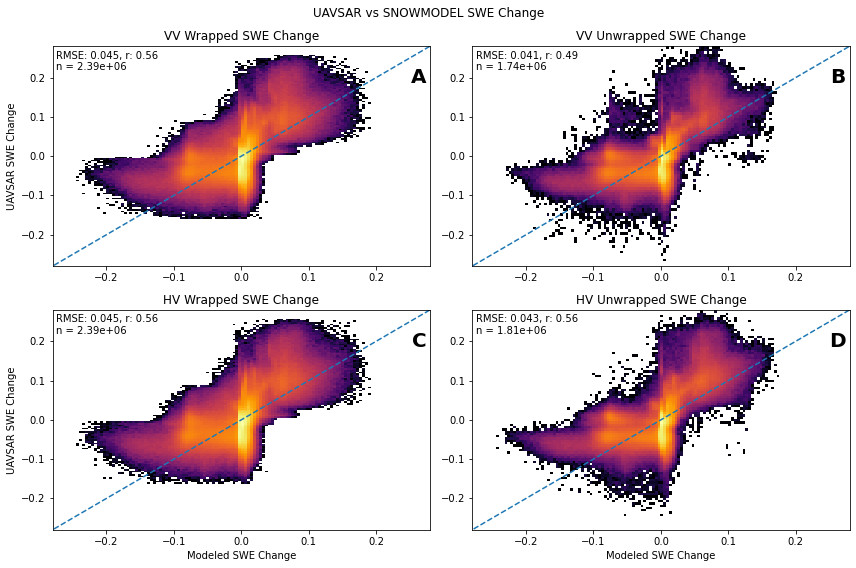

In [16]:
# loop through each flight pair and calculate rmse, r2, plot

import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, axes = plt.subplots(2, 2, figsize = (12, 8))

for i, band in enumerate(['VV', 'HV']):
    for j, var in enumerate(['int','unw']):
        xs = []
        ys = []
        var = f'uavsar_dSD_{var}'
        for fp in ncs_dir.glob('*.sd.model.nc'):
            ds = xr.open_dataset(fp)
            if f'uavsar_dSD_unw' in ds.data_vars:
                ds = ds
                xs.append(ds['swe'].values.ravel())
                ys.append(ds[var].sel(band = band).values.ravel() * (ds.attrs['mean_density']/ 997))

        # stack arrays
        xs = np.hstack(xs)
        ys = np.hstack(ys)

        xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys))]
        ys = ys[(~np.isnan(xs)) & (~np.isnan(ys)) ]
        xs = xs_tmp

        # range = [[-0.001, 0.002], [-0.1, 0.1]]
        axes[i, j].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno) #, range = range)

        if i == 1:
            axes[i, j].set_xlabel('Modeled SWE Change')
            
        if j == 0:
            axes[i, j].set_title(f'{band} Wrapped SWE Change')
        else:
            axes[i, j].set_title(f'{band} Unwrapped SWE Change')
        #axes[i].set_xlim(range[0])
        #axes[i].set_ylim(range[1])

        from sklearn.metrics import mean_squared_error
        rms = mean_squared_error(xs, ys, squared=False)

        from scipy.stats import pearsonr
        r, p = pearsonr(xs, ys)
        axes[i, j].text(.01, .98, f'RMSE: {rms:.2}, r: {r:.2}\nn = {len(xs):.2e}', ha='left', va='top', transform=axes[i, j].transAxes)
plt.suptitle('UAVSAR vs SNOWMODEL SWE Change')

axes[0, 0].set_ylabel('UAVSAR SWE Change')
axes[1, 0].set_ylabel('UAVSAR SWE Change')
# identity line
for ax in axes.ravel():
    ax.plot([-1,1], [-1,1], label = '1-to-1', linestyle = 'dashed')
    ax.set_xlim(-0.28, 0.28)
    ax.set_ylim(-0.28, 0.28)

ax_labs = {0:'A', 1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I'}
for i, ax in enumerate(axes.ravel()):
    ax.text(.99, .9, ax_labs[i], ha = 'right', va = 'top', transform=ax.transAxes, fontweight = 'bold', fontsize = 20)

plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/modeling_all_v1.png')

next

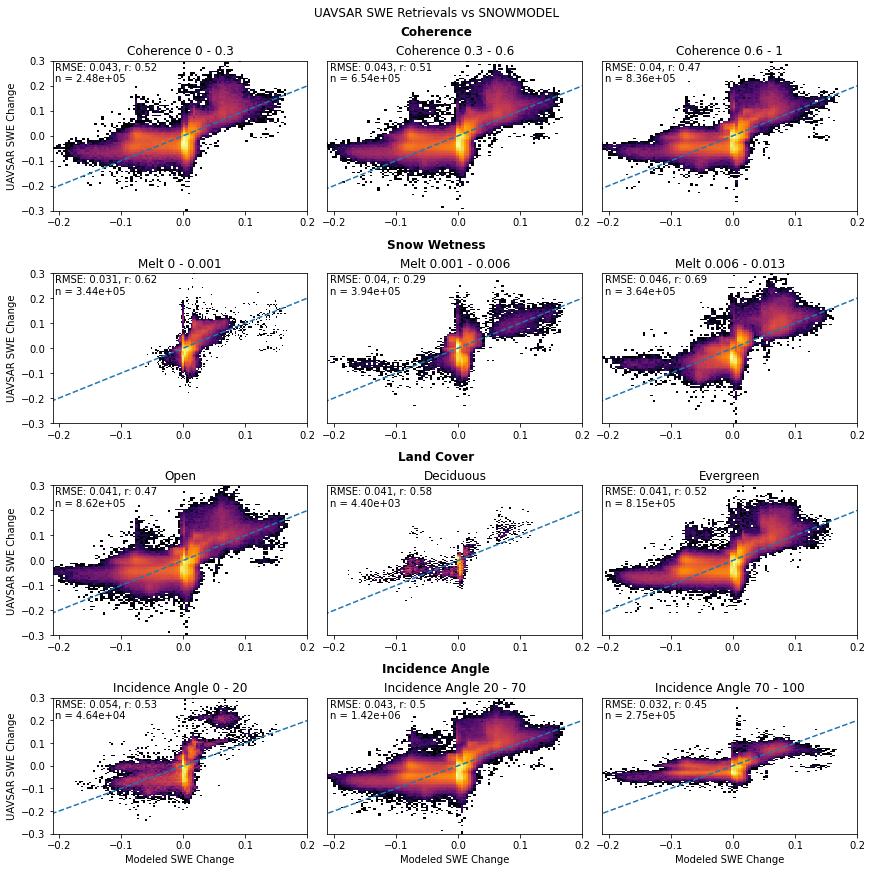

In [10]:
from stats import get_stats
import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

def clean_xs_ys(xs, ys):
        # stack arrays
    xs = np.hstack(xs)
    ys = np.hstack(ys)

    xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys)) & (np.isfinite(xs)) & (np.isfinite(ys))]
    ys = ys[(~np.isnan(xs)) & (~np.isnan(ys))  & (np.isfinite(xs)) & (np.isfinite(ys))]
    xs = xs_tmp

    return xs, ys

#https://www.mrlc.gov/downloads/sciweb1/shared/mrlc/metadata/nlcd_2019_land_cover_l48_20210604.xml
evergreen = [42]
decidous = [41, 43] # and mixed
open = [12, 31, 52, 71]
water = [11, 90, 95]
developed = [21, 22, 23, 24, 81, 82]

fig = plt.figure(constrained_layout=True, figsize = (12, 12))
fig.suptitle('UAVSAR SWE Retrievals vs SNOWMODEL')
ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for row, subfig in enumerate(subfigs):


    # create 1x3 subplots per subfig
    axes = subfig.subplots(nrows=1, ncols=3)

        # identity line
    for ax in axes.ravel():
        ax.plot([-1,1], [-1,1], label = '1-to-1', linestyle = 'dashed')

    if row == 0:
        subfig.suptitle(f'Coherence', fontweight = 'bold')
        for i, (coh_low, coh_high) in enumerate([[0, 0.3], [0.3, 0.6],[0.6, 1]]):
            xs = []
            ys = []
            var = f'uavsar_dSD_unw'
            for fp in ncs_dir.glob('*.sd.model.nc'):
                ds = xr.open_dataset(fp)
                # ds = ds.where(~ds['lc'].isin(water.extend(developed)))
                ds = ds.where((ds['cor'].sel(band = 'VV') < coh_high) & (ds['cor'].sel(band = 'VV') > coh_low))

                if var in ds.data_vars:
                    xs.append(ds['swe'].values.ravel())
                    ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))

            xs, ys = clean_xs_ys(xs, ys)

            rmse, r, n = get_stats(xs, ys)

            axes[i].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)

            axes[i].text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nn = {len(xs):.2e}', ha='left', va='top', transform=axes[i].transAxes)
            axes[i].set_title(f'Coherence {coh_low} - {coh_high}')

            if i == 0:
                axes[i].set_ylabel('UAVSAR SWE Change')
            else:
                axes[i].set_yticks([])

            # axes[i].set_xticks([])
        
    if row == 1:
        subfig.suptitle(f'Snow Wetness', fontweight = 'bold')
        for i, (low, high) in enumerate([[0, 0.001], [0.001, 0.006],[0.006, 0.013]]):
            xs = []
            ys = []
            var = f'uavsar_dSD_unw'

            for fp in ncs_dir.glob('*.sd.model.nc'):
                ds = xr.open_dataset(fp)
                # ds = ds.where(~ds['lc'].isin(water.extend(developed)))
                ds['melt_sum'] = ds['melt_t1'] + ds['melt_t2']
                ds = ds.where((ds['melt_sum'] < high) & (ds['melt_sum'] > low))

                if var in ds.data_vars:
                    xs.append(ds['swe'].values.ravel())
                    ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
            xs, ys = clean_xs_ys(xs, ys)

            rmse, r, n = get_stats(xs, ys)

            axes[i].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)

            axes[i].text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nn = {len(xs):.2e}', ha='left', va='top', transform=axes[i].transAxes)
            axes[i].set_title(f'Melt {low} - {high}')

            if i == 0:
                axes[i].set_ylabel('UAVSAR SWE Change')
            else:
                axes[i].set_yticks([])
            # axes[i].set_xticks([])
    
    if row == 2:
        subfig.suptitle(f'Land Cover', fontweight = 'bold')
        for i, (lc_list) in enumerate([open, decidous, evergreen]):
            xs = []
            ys = []
            var = f'uavsar_dSD_unw'

            for fp in ncs_dir.glob('*.sd.model.nc'):
                ds = xr.open_dataset(fp)
                # ds = ds.where(~ds['lc'].isin(water.extend(developed)))
                ds = ds.where(ds['lc'].isin(lc_list))

                if var in ds.data_vars:
                    xs.append(ds['swe'].values.ravel())
                    ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
            xs, ys = clean_xs_ys(xs, ys)

            rmse, r, n = get_stats(xs, ys)

            axes[i].hist2d(xs, ys, bins = 100, norm = mpl.colors.LogNorm(), cmap=mpl.cm.inferno)

            axes[i].text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nn = {len(xs):.2e}', ha='left', va='top', transform=axes[i].transAxes)
            if i == 0:
                axes[i].set_title(f'Open')
                axes[i].set_ylabel('UAVSAR SWE Change')
            elif i == 1:
                axes[i].set_title('Deciduous')
                axes[i].set_yticks([])

            elif i == 2:
                axes[i].set_title('Evergreen')
                axes[i].set_yticks([])
    
    if row == 3:
        subfig.suptitle(f'Incidence Angle', fontweight = 'bold')
        for i, (low, high) in enumerate([[0, np.deg2rad(20)], [np.deg2rad(20), np.deg2rad(70)],[np.deg2rad(70), np.deg2rad(100)]]):
            xs = []
            ys = []
            var = 'uavsar_dSD_unw'

            for fp in ncs_dir.glob('*.sd.model.nc'):
                ds = xr.open_dataset(fp)
                ds = ds.where((ds['inc'] < high) & (ds['inc'] > low))

                if var in ds.data_vars:
                    xs.append(ds['swe'].values.ravel())
                    ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
            xs, ys = clean_xs_ys(xs, ys)

            rmse, r, n = get_stats(xs, ys)

            axes[i].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno)

            axes[i].text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nn = {len(xs):.2e}', ha='left', va='top', transform=axes[i].transAxes)
            axes[i].set_title(f'Incidence Angle {round(np.rad2deg(low))} - {round(np.rad2deg(high))}')

            if i == 0:
                axes[i].set_ylabel('UAVSAR SWE Change')
            else:
                axes[i].set_yticks([])
            # axes[i].set_xticks([])
            axes[i].set_xlabel('Modeled SWE Change')

for ax in fig.get_axes():
    ax.set_xlim(-0.21, 0.2)
    ax.set_ylim(-0.3, 0.3)

plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/modeling_binned_v4.png')

100%|██████████| 34/34 [00:58<00:00,  1.71s/it]


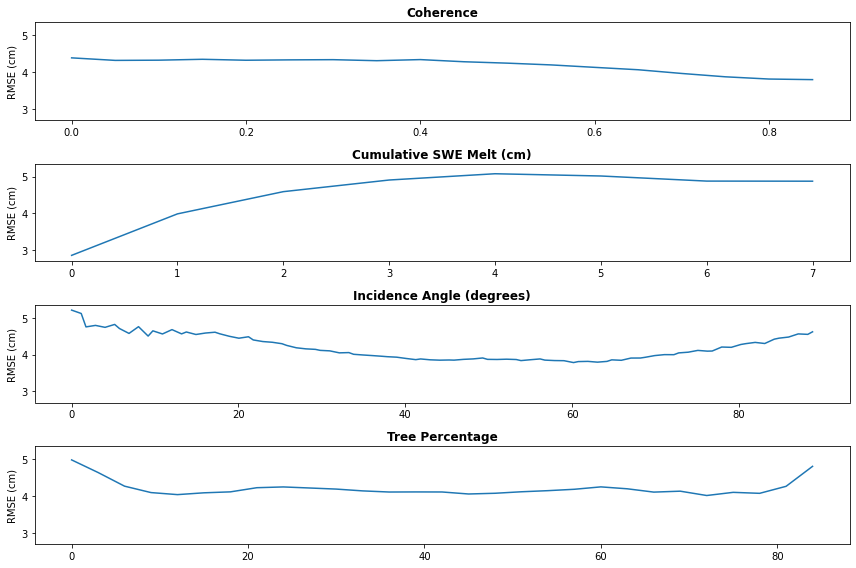

In [2]:
from stats import get_stats
import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

def clean_xs_ys(xs, ys):
        # stack arrays
    xs = np.hstack(xs)
    ys = np.hstack(ys)

    xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys)) & (np.isfinite(xs)) & (np.isfinite(ys))]
    ys = ys[(~np.isnan(xs)) & (~np.isnan(ys))  & (np.isfinite(xs)) & (np.isfinite(ys))]
    xs = xs_tmp

    return xs, ys

def make_iter(start, end, step):
    lows = np.round(np.arange(start, end, step), 2)
    highs = np.round(np.arange(step, end + step, step), 2)
    iters = zip(lows, highs)
    return iters, len(lows)

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, axes = plt.subplots(4, figsize = (12, 8))
var = f'uavsar_dSD_unw'
band = 'VV'

# coherence
iters, n = make_iter(0, 0.9, 0.05)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['cor'].sel(band = band) < high) & (ds['cor'].sel(band = band) > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = band).values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue

    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(low)

ax_cor = axes[0]
ax_cor.plot(lows, np.multiply(rmses, 100))
ax_cor.set_title('Coherence', weight = 'bold')

# snow wetness
iters, n = make_iter(0, 0.075, 0.01) #0.01
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['cum_melt'] < high) & (ds['cum_melt'] > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(low * 100)

ax_melt = axes[1]
ax_melt.plot(lows, np.multiply(rmses, 100))
ax_melt.set_title('Cumulative SWE Melt (cm)', weight = 'bold')

# incidence angle
iters, n = make_iter(0, np.deg2rad(90), np.deg2rad(1))
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    inc = xr.open_dataset(next(ncs_dir.glob('*.sd.model.nc')))['inc']
    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((inc < high) & (inc > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(np.round(np.rad2deg(low), 2))

ax_inc = axes[2]
ax_inc.plot(lows, np.multiply(rmses, 100))
ax_inc.set_title('Incidence Angle (degrees)', weight = 'bold')

# tree coverage
if 'id_tree' not in locals():
    trees = rxa.open_rasterio('/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/nlcd/nlcd_2016_treecanopy_2019_08_31.img').squeeze('band')
    trees_clip = trees.rio.clip_box(*ds.rio.bounds(), crs = ds.rio.crs)
    id_tree = trees.rio.reproject_match(ds['inc'])

iters, n = make_iter(0, 100, 3)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((id_tree < high) & (id_tree > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(np.round(low, 2))

ax_tree = axes[3]
ax_tree.plot(lows, np.multiply(rmses, 100))
ax_tree.set_title('Tree Percentage', weight = 'bold')

# set all axes
for ax in axes:
    ax.set_ylabel('RMSE (cm)')
    ax.set_ylim(2.7, 5.35)

plt.tight_layout()
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/rmse_param_plots_v2.png')

100%|██████████| 34/34 [01:08<00:00,  2.02s/it]


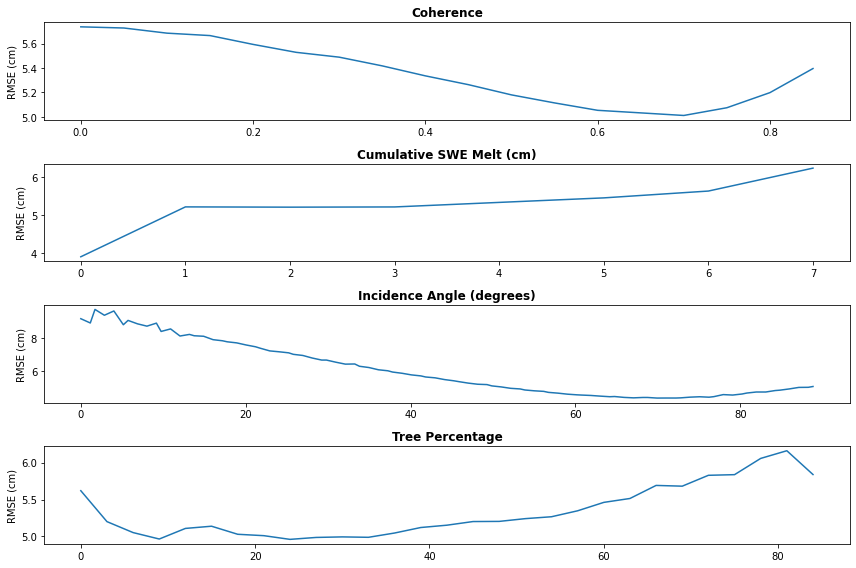

In [3]:
from stats import get_stats
import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

def clean_xs_ys(xs, ys):
        # stack arrays
    xs = np.hstack(xs)
    ys = np.hstack(ys)

    xs_tmp = xs[(~np.isnan(xs)) & (~np.isnan(ys)) & (np.isfinite(xs)) & (np.isfinite(ys))]
    ys = ys[(~np.isnan(xs)) & (~np.isnan(ys))  & (np.isfinite(xs)) & (np.isfinite(ys))]
    xs = xs_tmp

    return xs, ys

def make_iter(start, end, step):
    lows = np.round(np.arange(start, end, step), 2)
    highs = np.round(np.arange(step, end + step, step), 2)
    iters = zip(lows, highs)
    return iters, len(lows)

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

fig, axes = plt.subplots(4, figsize = (12, 8))
var = f'uavsar_dSD_int'
band = 'VV'

# coherence
iters, n = make_iter(0, 0.9, 0.05)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['cor'].sel(band = band) < high) & (ds['cor'].sel(band = band) > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = band).values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue

    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(low)

ax_cor = axes[0]
ax_cor.plot(lows, np.multiply(rmses, 100))
ax_cor.set_title('Coherence', weight = 'bold')

# snow wetness
iters, n = make_iter(0, 0.075, 0.01) #0.01
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((ds['cum_melt'] < high) & (ds['cum_melt'] > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(low * 100)

ax_melt = axes[1]
ax_melt.plot(lows, np.multiply(rmses, 100))
ax_melt.set_title('Cumulative SWE Melt (cm)', weight = 'bold')

# incidence angle
iters, n = make_iter(0, np.deg2rad(90), np.deg2rad(1))
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    inc = xr.open_dataset(next(ncs_dir.glob('*.sd.model.nc')))['inc']
    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((inc < high) & (inc > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(np.round(np.rad2deg(low), 2))

ax_inc = axes[2]
ax_inc.plot(lows, np.multiply(rmses, 100))
ax_inc.set_title('Incidence Angle (degrees)', weight = 'bold')

# tree coverage
if 'id_tree' not in locals():
    trees = rxa.open_rasterio('/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/nlcd/nlcd_2016_treecanopy_2019_08_31.img').squeeze('band')
    trees_clip = trees.rio.clip_box(*ds.rio.bounds(), crs = ds.rio.crs)
    id_tree = trees.rio.reproject_match(ds['inc'])

iters, n = make_iter(0, 100, 3)
rmses = []
lows = []
for i, (low, high) in enumerate(tqdm(iters, total = n)):
    xs = []
    ys = []

    for fp in ncs_dir.glob('*.sd.model.nc'):
        ds = xr.open_dataset(fp)
        ds = ds.where((id_tree < high) & (id_tree > low))

        if var in ds.data_vars:
            xs.append(ds['swe'].values.ravel())
            ys.append(ds[var].sel(band = 'VV').values.ravel() * (ds.attrs['mean_density']/ 997))
    xs, ys = clean_xs_ys(xs, ys)

    if len(xs) < 50:
        continue
    rmse, r, n = get_stats(xs, ys)
    rmses.append(rmse)
    lows.append(np.round(low, 2))

ax_tree = axes[3]
ax_tree.plot(lows, np.multiply(rmses, 100))
ax_tree.set_title('Tree Percentage', weight = 'bold')

# set all axes
for ax in axes:
    ax.set_ylabel('RMSE (cm)')
    # ax.set_ylim(2.7, 5.35)

plt.tight_layout()
# plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/model/rmse_param_plots_v2.png')

In [1]:
# loop through each flight pair and calculate rmse, r2, plot

import xarray as xr
import numpy as np
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

from stats import clean_xs_ys, get_stats

# loop through each flight pair and calculate rmse, r2, plot

ncs_dir = Path('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model')

# fig, axes = plt.subplots(2, 2, figsize = (12, 8))


xs = []
ys = []

band = 'VV'
var = f'uavsar_dSD_unw'
for fp in ncs_dir.glob('*.sd.model.nc'):
    ds = xr.open_dataset(fp)
    if var not in ds.data_vars:
        continue

    xs = ds['swe'].values.ravel()
    ys= ds[var].sel(band = band).values.ravel() * (ds.attrs['mean_density']/ 997)

    rmse, r, n = get_stats(xs, ys)

    print(fp)
    print(ds[var].sel(band = 'VV').mean().data)
    print(rmse)

/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/052_2021-03-03_2021-03-10.sd.model.nc
-0.17646283
0.05439853992421393
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2021-03-16_2021-03-22.sd.model.nc
-0.002302041
0.048504222507791454
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2021-03-10_2021-03-16.sd.model.nc
-0.13004294
0.03925971292143373
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2021-03-03_2021-03-10.sd.model.nc
-0.17411049
0.051141629480670046
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/052_2021-02-10_2021-03-03.sd.model.nc
0.42355323
0.0717183899750433
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/052_2021-02-03_2021-02-10.sd.model.nc
-0.059383906
0.02888252886661115
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2020-02-21_2020-03-11.sd.model.nc
-0.20008214
0.06848404223015575
/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2021-01-15_2021-01-20.sd.model.nc
0.011580648
0.01824964618385949
/bsuscratch/zacharykeskinen/data/uavsa

In [19]:
ds = xr.open_dataset('/bsuscratch/zacharykeskinen/data/uavsar/ncs/model/232_2020-02-13_2020-02-21.sd.model.nc')

In [26]:
ds[var].sel(band = 'VV').rio.to_raster(Path('~/uv_sd.tif').expanduser())

In [27]:
ds['swe'].where(~ds[var].sel(band = 'VV').isnull()).rio.to_raster(Path('~/model_sd.tif').expanduser())